<div style="width: 38.5%;">
    <p><strong>City College of San Francisco</strong><p>
    <hr>
    <p>MATH 108 - Foundations of Data Science</p>
</div>

# Lecture 33: Regression Inference

Associated Textbook Sections: [16.0 - 16.3](https://inferentialthinking.com/chapters/16/Inference_for_Regression.html)

<h2>Set Up the Notebook<h2>

In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")
    
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

def add_regression_to_table(t, x, y):
    """ Returns a new table with 'Fitted value' and 'Residual' columns added """
    t_with_extra_cols = t.with_columns(
        'Fitted value', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    return t_with_extra_cols

## Regression Model

### A "Model": Signal + Noise

<img src="img/lec33_signal_noise.png" width=80%>

### What We Get To See

<img src="img/lec33_what_we_see.png" width=50%>

### Demo: Regression Model

Explore a few examples showing the true line, the points created, and the line produced from the sample.

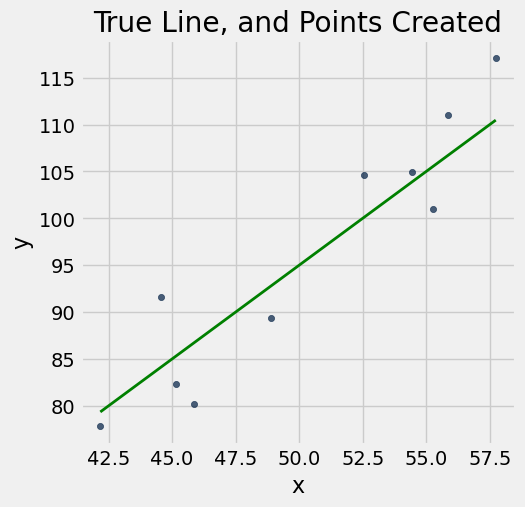

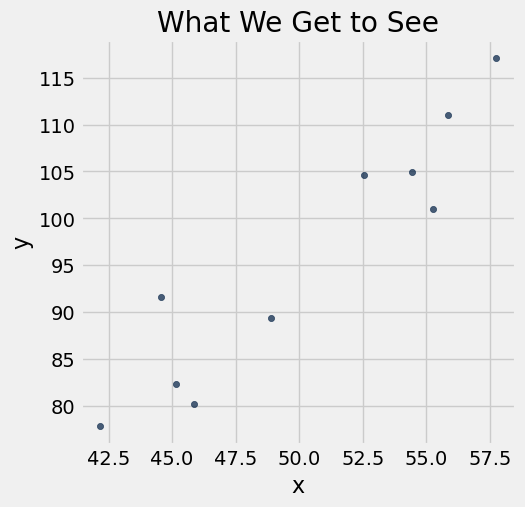

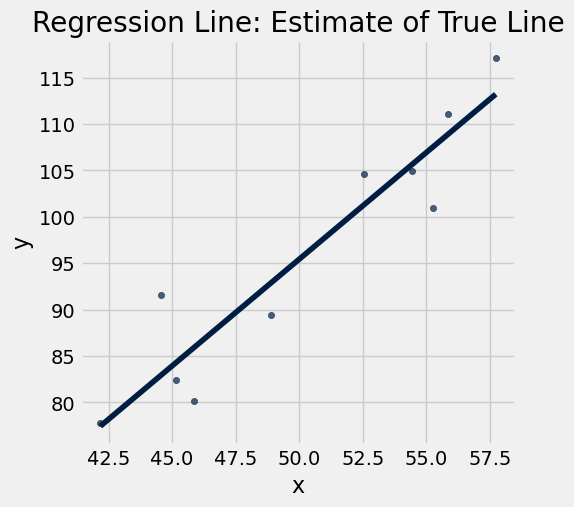

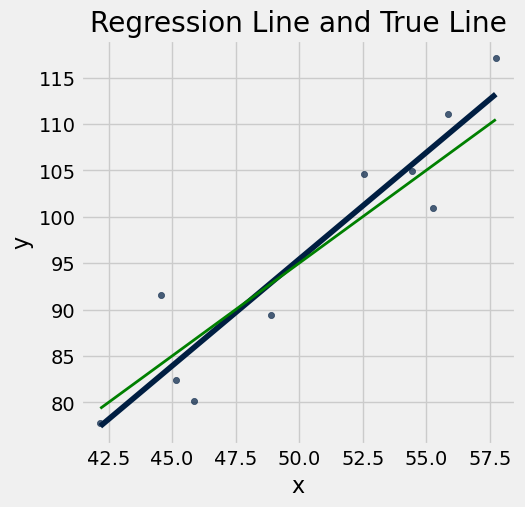

In [2]:
draw_and_compare(2, -5, 10)

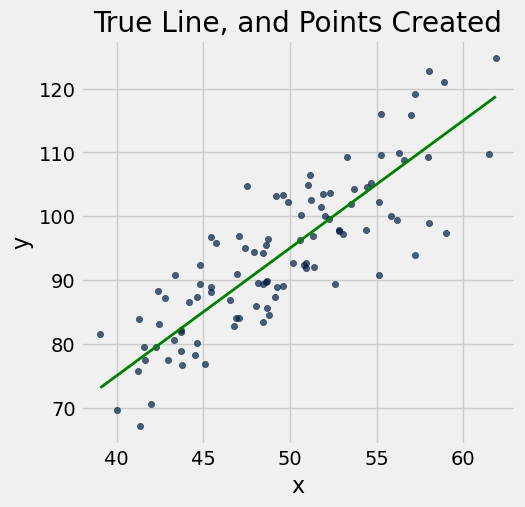

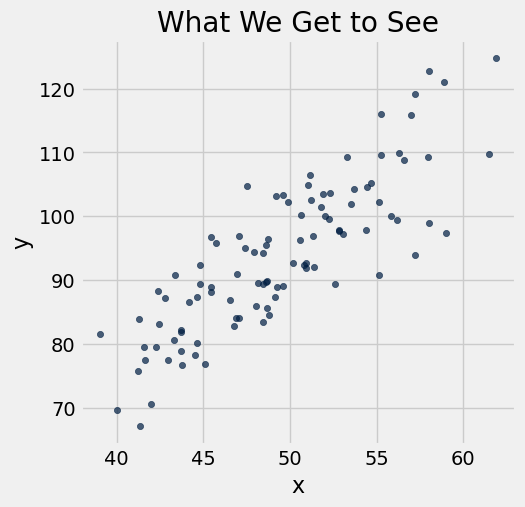

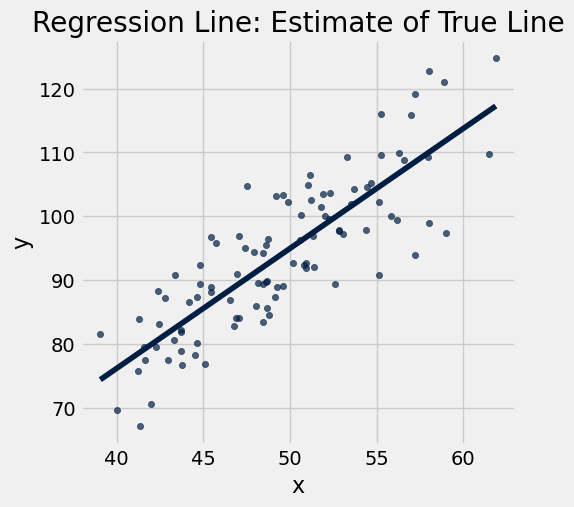

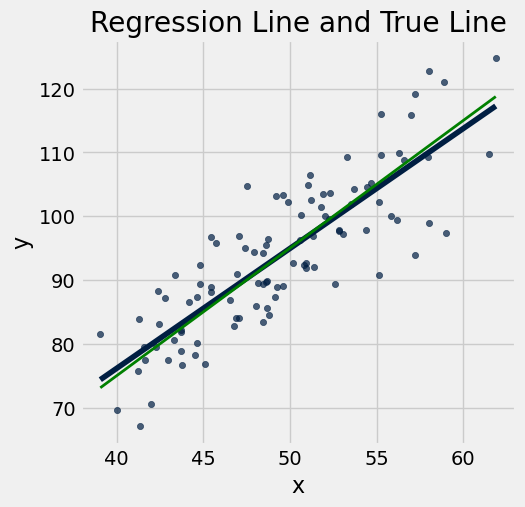

In [3]:
draw_and_compare(2, -5, 100)

## Prediction Variability

### Regression Prediction

If the data come from the regression model:
* The "true value" of the response $y$ at a given value of $x$ is the height of the true line at $x$
* We can't see the true line, so we have to estimate this height
* The regression line is most likely close to the true line
* Given a new value of $x$, predict $y$ by finding the point on the regression line at that $x$.

### Demo: Prediction

Explore the variability in the linear regression prediction of `Birth Weight` based on `Gestational Days` using the `baby.csv` dataset.

In [4]:
births = Table.read_table('data/baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


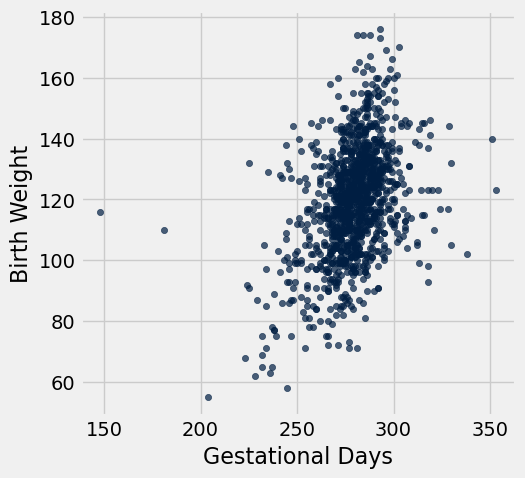

In [5]:
births.scatter('Gestational Days', 'Birth Weight')

In [6]:
births = births.where('Gestational Days', are.between(240, 320))

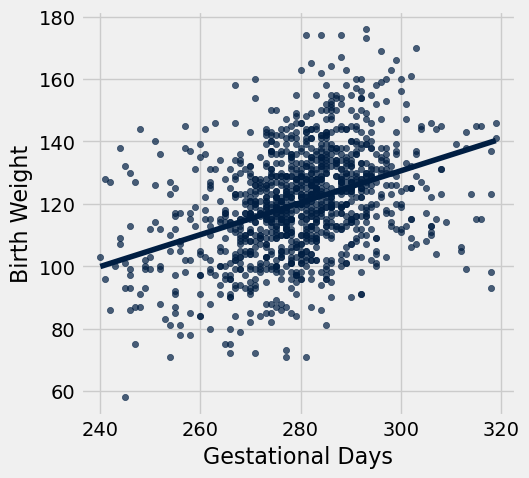

In [7]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [8]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [9]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.53859795467929

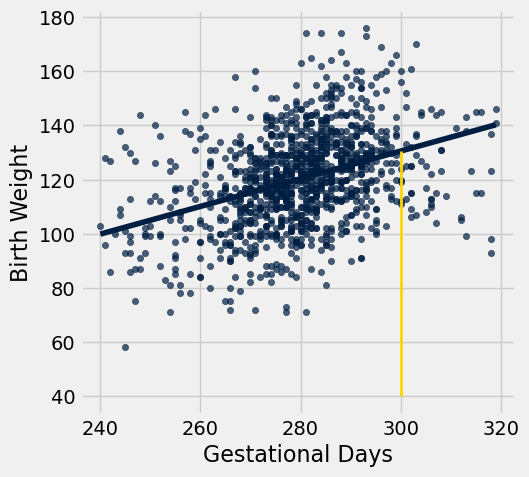

In [10]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='gold', lw=2);

### Confidence Interval for Prediction

* Bootstrap the scatter plot
* Get a prediction for y using the regression line that goes through the resampled plot
* Repeat the two steps above many times
* Draw the empirical histogram of all the predictions.
* Get the "middle 95%" interval.
* That's an approximate 95% confidence interval for the height of the true line at y.

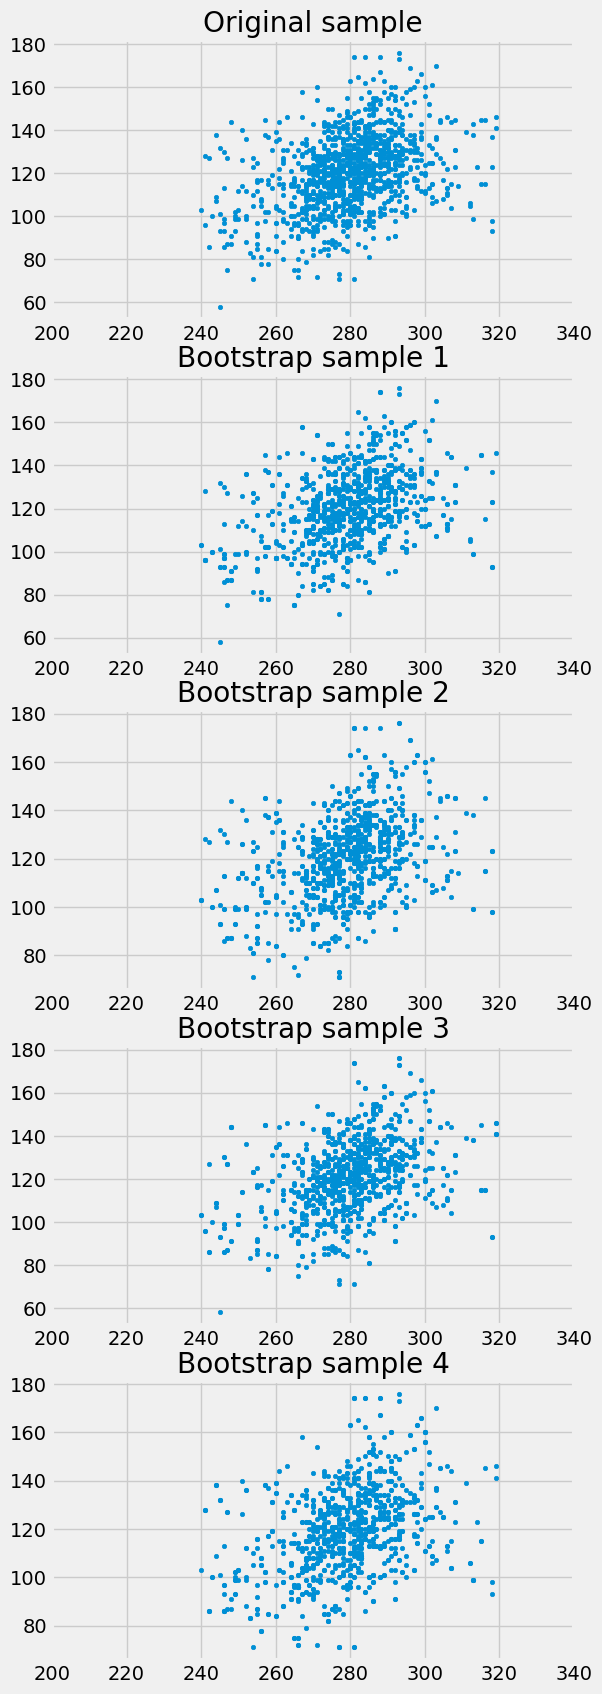

In [11]:
plots.figure(figsize=(6, 20))
plots.subplot(5, 1, 1)
plots.scatter(births[1], births[0], s=10)
plots.xlim([200, 340])
plots.title('Original sample')

for i in np.arange(1, 5, 1):
    plots.subplot(5,1,i+1)
    rep = births.sample()
    plots.scatter(rep[1], rep[0], s=10)
    plots.xlim([200, 340])
    plots.title('Bootstrap sample '+str(i))

Predicted y from bootstramp sample was 129.252149583
Predicted y from bootstramp sample was 128.84439999
Predicted y from bootstramp sample was 129.770544108
Predicted y from bootstramp sample was 131.019887831


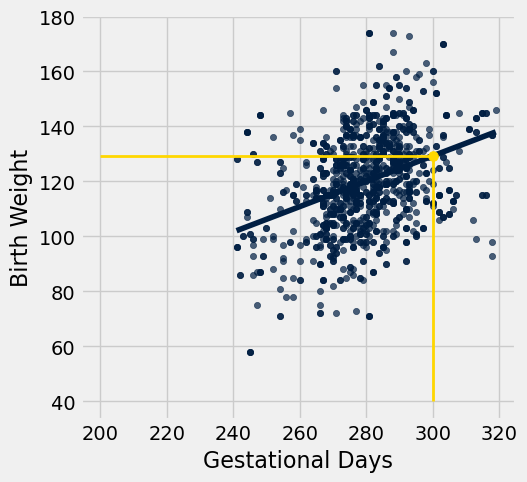

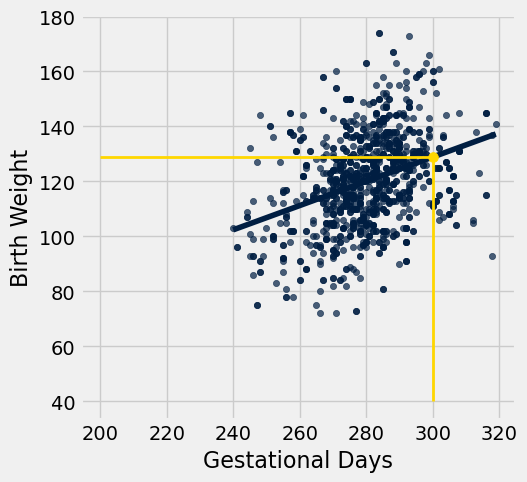

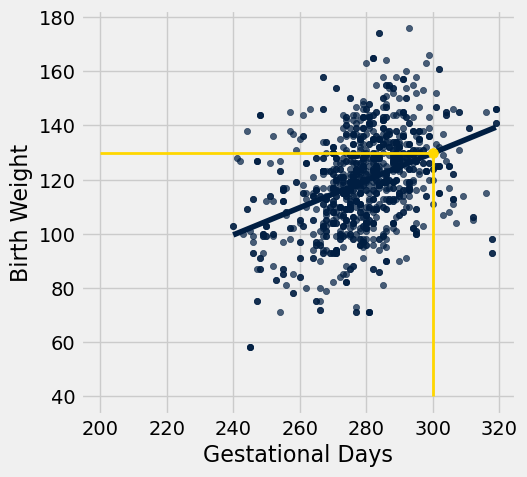

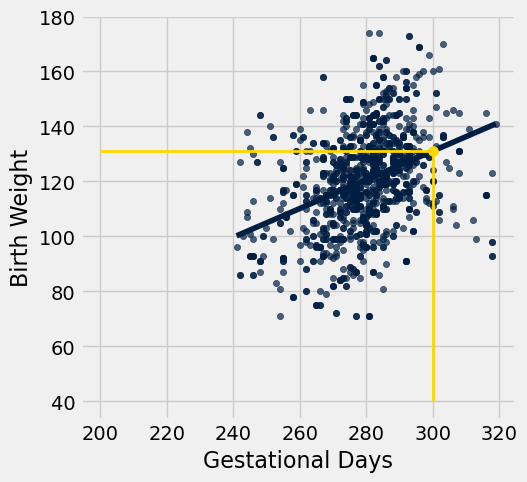

In [12]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstramp sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([x, x], [40, predicted_y], color='gold', lw=2);
    plots.plot([200, x], [predicted_y, predicted_y], color='gold', lw=2);

Observe the variation in the regression lines made from each sample.

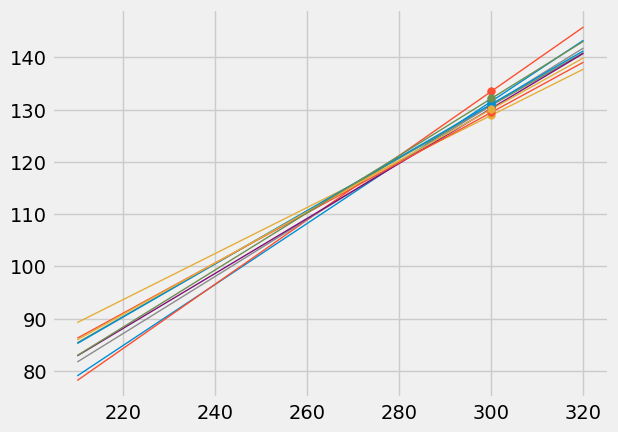

In [13]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

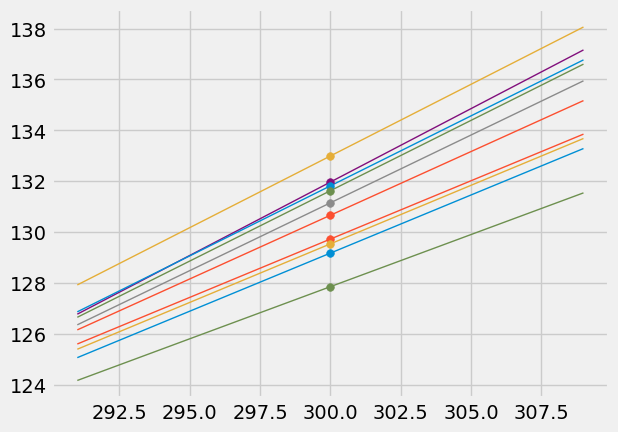

In [14]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

### Demo: Confidence Interval for Prediction

Construct a confidence interval for the height of the true line.

In [15]:
def bootstrap_prediction(t, x, y, new_x, repetitions=1000):

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')') 

Approximate 95%-confidence interval for height of true line:
128.659737878 132.557004523 (width = 3.89726664522 )


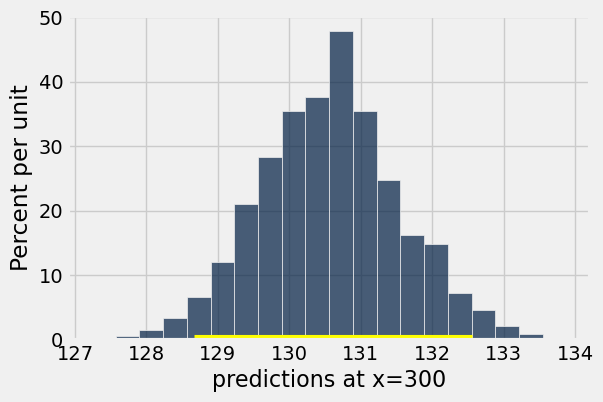

In [16]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)

### Predictions at Different Values of $x$

* Since $y$ is correlated with $x$, the predicted values of $y$ depend on the value of $x$.
* The width of the prediction's CI also depends on $x$.
* Typically, intervals are wider for values of $x$ that are further away from the mean of $x$.

### Demo: Predictions at Different Values of $X$

Explore predictions made for different values of $x$.

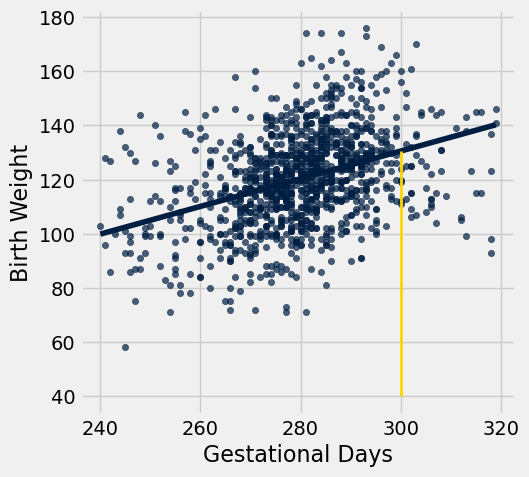

In [17]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='gold', lw=2);

Approximate 95%-confidence interval for height of true line:
78.5182920474 90.1311502639 (width = 11.6128582164 )


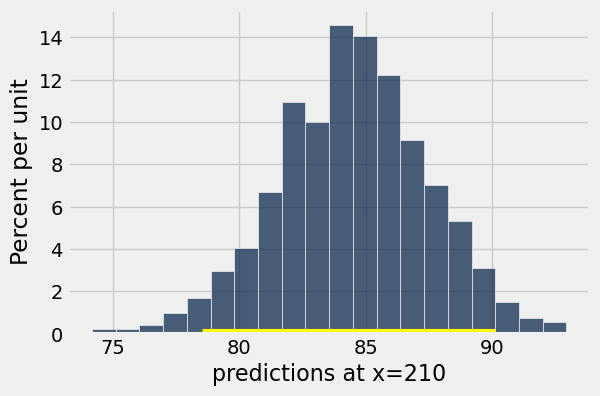

In [18]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 210)

Approximate 95%-confidence interval for height of true line:
119.35327329 121.418689476 (width = 2.06541618572 )


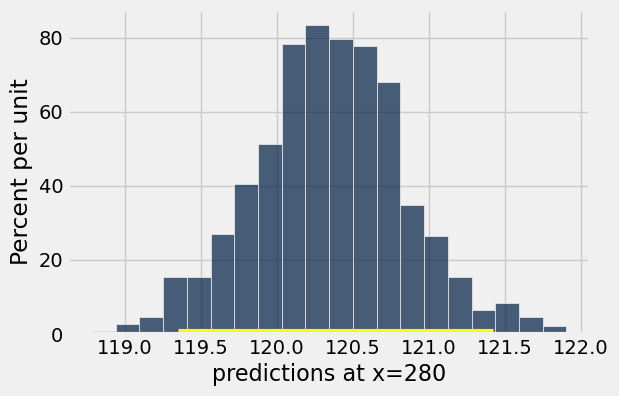

In [19]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

In [20]:
np.mean(births.column('Gestational Days'))

279.72080772607552

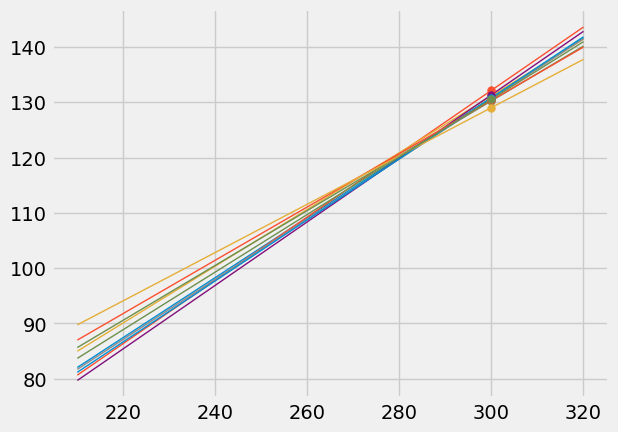

In [21]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

## The True Slope

### Confidence Interval for True Slope

* Bootstrap the scatter plot.
* Find the slope of the regression line through the bootstrapped plot.
* Repeat.
* Draw the empirical histogram of all the generated slopes.
* Get the "middle 95%" interval.
* That's an approximate 95% confidence interval for the slope of the true line.


### Demo: Inference for the Slope

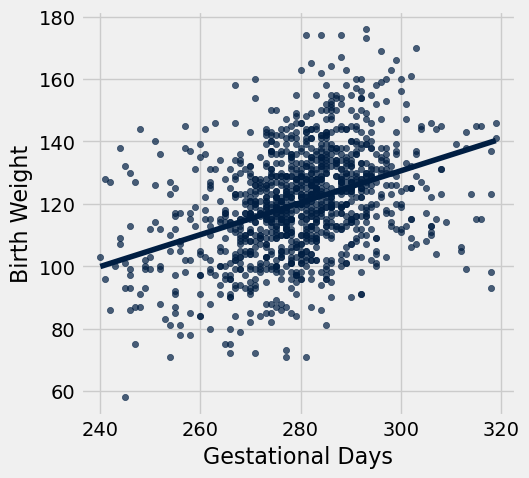

In [22]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [23]:
slope(births, 'Gestational Days', 'Birth Weight')

0.5110166711567975

In [24]:
def bootstrap_slope(t, x, y, repetitions=5000):
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

Slope of regression line: 0.511016671157
Approximate 95%-confidence interval for the slope of the true line:
0.428314147191 to 0.59432451695


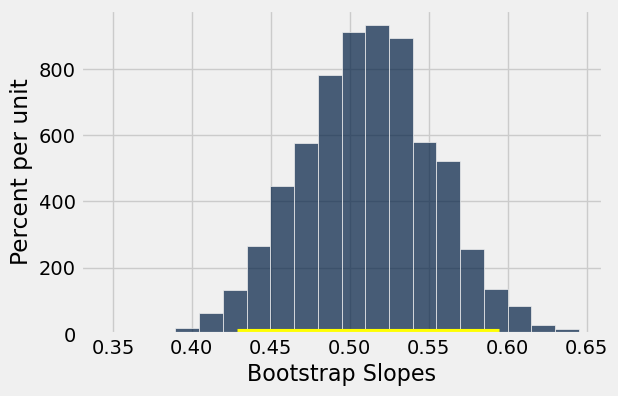

In [25]:
bootstrap_slope(births, 'Gestational Days', 'Birth Weight', 2500)

### Rain on the Regression Parade

<img src="img/lec33_rain.png" width=60%>

### Demo: Rain on the Regression Parade

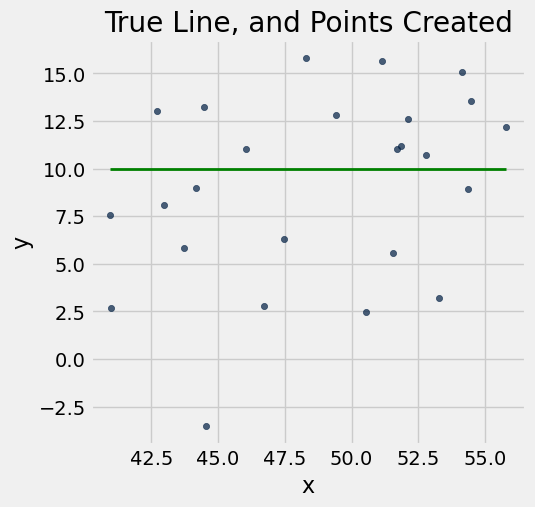

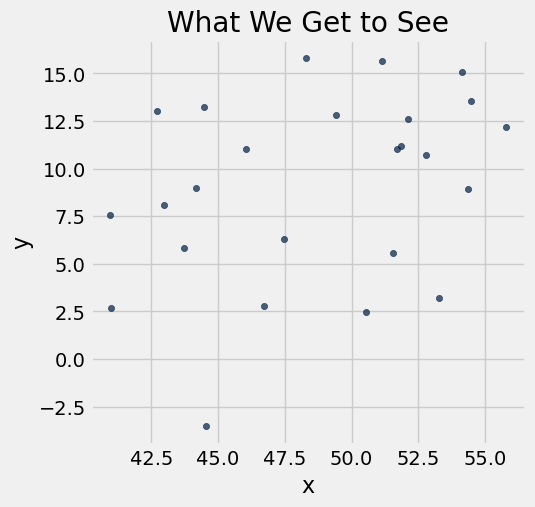

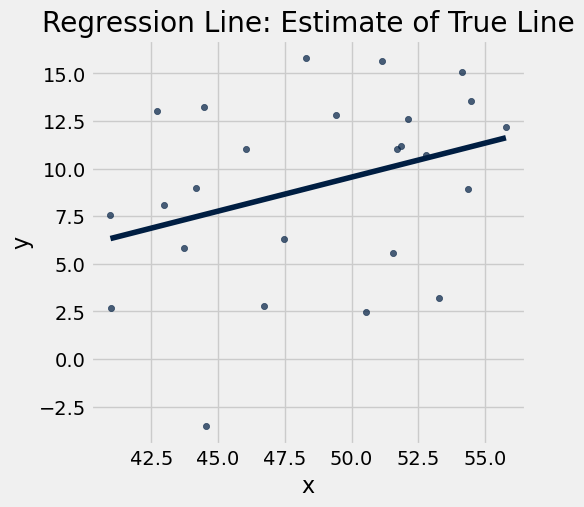

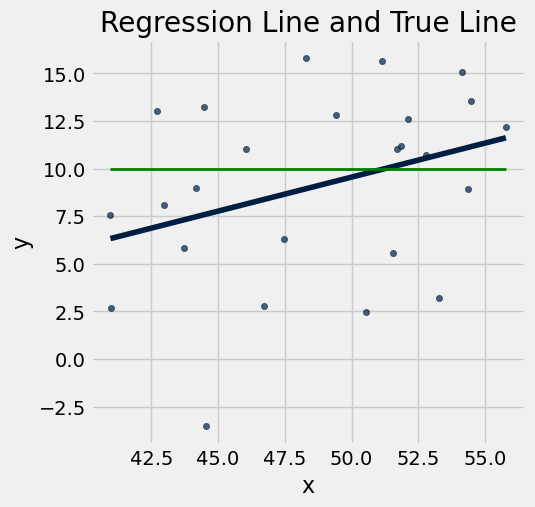

In [26]:
draw_and_compare(0, 10, 25)

### Test Whether There Really is a Slope

* Null hypothesis: The slope of the true line is 0.
* Alternative hypothesis: No, it's not.
* Method:
    * Construct a bootstrap confidence interval for the true slope.
    * If the interval doesn't contain 0, the data are more consistent with the alternative
    * If the interval does contain 0, the data are more consistent with the null


### Demo: Test Whether There Really is a Slope

**Null Hypothesis.** Slope of true line = 0.

**Alternative Hypothesis.** Slope of true line is not 0.

In [27]:
slope(births, 'Maternal Age', 'Birth Weight')

0.10714722656623907

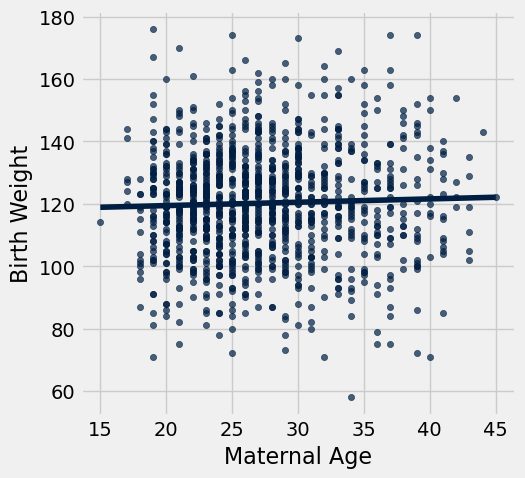

In [28]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)

Slope of regression line: 0.107147226566
Approximate 95%-confidence interval for the slope of the true line:
-0.084881131522 to 0.29855772499


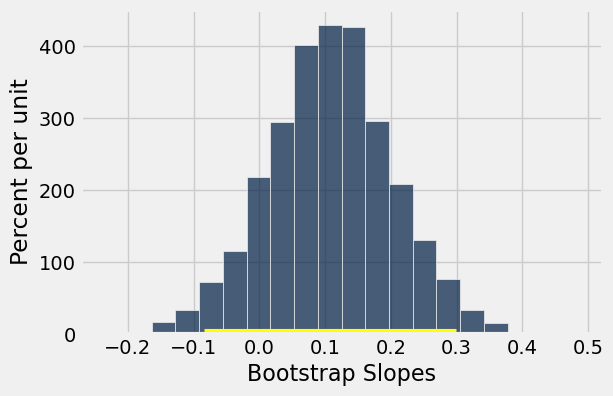

In [29]:
bootstrap_slope(births, 'Maternal Age', 'Birth Weight', 2500)

<footer>
    <hr>
    <p>Adopted from UC Berkeley DATA 8 course materials.</p>
    <p>This content is offered under a <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">CC Attribution Non-Commercial Share Alike</a> license.</p>
</footer>